#**This is a Project that studies the different cuisines in the city of Toronto. It then clusters the neighborhoods in Toronto on the basis of similarity in cuisines and identify the primary cuisine in each cluster.**


In [109]:
#Import the required libraries
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import matplotlib.pyplot as plot

In [112]:
#Obtain Postal Code, Borough, and Neighborhood information from Wikipedia
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header = 0)

#Obtain the first table from the wikipedia page in a dataframe
toronto_data = table[0]
toronto_data.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [113]:
toronto_data.rename(columns = {"Postal Code": "PostCode", "Neighborhood": "Neighborhood"}, inplace = True)

#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
toronto_data.drop(toronto_data[toronto_data.Borough == 'Not assigned'].index, inplace=True)
#df.head()

#Combine the neighborhoods that exists in one postal code
toronto_data = toronto_data.groupby(['PostCode', 'Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index()
#df.head()

#Change unassigned Neighborhood to its Borough's name
toronto_data.loc[85,'Neighborhood'] = 'Queen\'s Park'

toronto_data.head()

,PostCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [114]:
#Create a dataframe of the latitude and longitudes of the Neighborhoods in Toronto
toronto_latlong = pd.read_csv("http://cocl.us/Geospatial_data")
toronto_latlong.rename(columns = {"Postal Code": "PostCode"}, inplace = True)
toronto_latlong.head()

,PostCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [115]:
#Join the Lat and Long dataframe to Neighborhoods dataframe
toronto_data.set_index("PostCode")
toronto_latlong.set_index("PostCode")
toronto_neighbor=pd.merge(toronto_data, toronto_latlong)
toronto_neighbor.head()


,PostCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [117]:
#Foursquare Credentials
CLIENT_ID = '*******************************' # your Foursquare ID
CLIENT_SECRET = '******************************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: *******************************
CLIENT_SECRET:******************************


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [20]:
#Get the venues in each neighborhood
toronto_neighbor_venues = getNearbyVenues(names=toronto_neighbor['Neighborhood'],
                                   latitudes=toronto_neighbor['Latitude'],
                                   longitudes=toronto_neighbor['Longitude']
                                  )
toronto_neighbor_venues.head()

Found 2132 venues in 103 neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [21]:
#Filter the venues to only Restaurant in each neighborhood. 
toronto_neighbor_venues_cuisine=toronto_neighbor_venues[toronto_neighbor_venues['Venue Category'].str.contains('Restaurant')]
print('There are {} distinct Venues in {} cuisines.'.format(
    len(toronto_neighbor_venues_cuisine['Venue'].unique()),len(toronto_neighbor_venues_cuisine['Venue Category'].unique())))



There are 354 distinct Venues in 50 cuisines.


In [22]:
#Venues per Neighborhood
toronto_neighbor_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,3,3,3,3,3,3
Woodbine Heights,8,8,8,8,8,8


In [24]:
# Study each neighborhood
toronto_each_neigborhood = pd.get_dummies(toronto_neighbor_venues_cuisine[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_each_neigborhood['Neighborhood'] = toronto_neighbor_venues_cuisine['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_each_neigborhood.columns[-1]] + list(toronto_each_neigborhood.columns[:-1])
toronto_each_neigborhood = toronto_each_neigborhood[fixed_columns]

toronto_each_neigborhood


,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Cedarbrae,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,"New Toronto, Mimico South, Humber Bay Shores",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2083,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2109,Westmount,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2114,Westmount,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#To find the mean of the frequency of occurrence of each category in each neighborhood
toronto_grouped = toronto_each_neigborhood.groupby('Neighborhood').mean().reset_index()
toronto_grouped


,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,Bayview Village,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,"Bedford Park, Lawrence Manor East",0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.181818,0.000000,0.0,0.090909,0.0,0.0,0.090909,0.0,0.000000,0.000000
4,Berczy Park,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.166667,0.0,0.083333,0.0,0.0,0.083333,0.0,0.083333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Victoria Village,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
60,Westmount,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
61,"Wexford, Maryvale",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
62,"Willowdale, Willowdale East",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090909,0.000000,0.0,0.181818,0.0,0.0,0.000000,0.0,0.000000,0.090909


In [27]:
#A Function to find the most common venues in each neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_neighbor_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighbor_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
#neighborhoods_venues_sorted->toronto_neighbor_venues_sorted
for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighbor_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighbor_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant,Comfort Food Restaurant,Greek Restaurant,American Restaurant,Thai Restaurant,Brazilian Restaurant
4,Berczy Park,Seafood Restaurant,Restaurant,Comfort Food Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Eastern European Restaurant,Greek Restaurant,Sushi Restaurant,Thai Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
59,Victoria Village,Portuguese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
60,Westmount,Chinese Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
61,"Wexford, Maryvale",Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
62,"Willowdale, Willowdale East",Ramen Restaurant,Sushi Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Indonesian Restaurant,Fast Food Restaurant,Japanese Restaurant,Restaurant,French Restaurant,Filipino Restaurant


In [32]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 
kmeans.labels_

#Add the Cluster labels to the toronto neighborhood data
toronto_neighbor_venues_sorted['Cluster Labels'] = kmeans.labels_
toronto_neighbor_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,1
1,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,1
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,1
3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Restaurant,Indian Restaurant,Sushi Restaurant,Japanese Restaurant,Comfort Food Restaurant,Greek Restaurant,American Restaurant,Thai Restaurant,Brazilian Restaurant,1
4,Berczy Park,Seafood Restaurant,Restaurant,Comfort Food Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Eastern European Restaurant,Greek Restaurant,Sushi Restaurant,Thai Restaurant,1
...,...,...,...,...,...,...,...,...,...,...,...,...
59,Victoria Village,Portuguese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,1
60,Westmount,Chinese Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,1
61,"Wexford, Maryvale",Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,1
62,"Willowdale, Willowdale East",Ramen Restaurant,Sushi Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Indonesian Restaurant,Fast Food Restaurant,Japanese Restaurant,Restaurant,French Restaurant,Filipino Restaurant,1


In [60]:
toronto_neighbor_venues_sorted[['Neighborhood','1st Most Common Venue','Cluster Labels']]
#toronto_neighbor_venues_sorted.groupby('1st Most Common Venue').count()
most_common_1=toronto_neighbor_venues_sorted[['Neighborhood','1st Most Common Venue']]
most_common_2=toronto_neighbor_venues_sorted[['Neighborhood','2nd Most Common Venue']]
df_2=most_common_2.groupby('2nd Most Common Venue').count()
df_1=most_common_1.groupby('1st Most Common Venue').count()


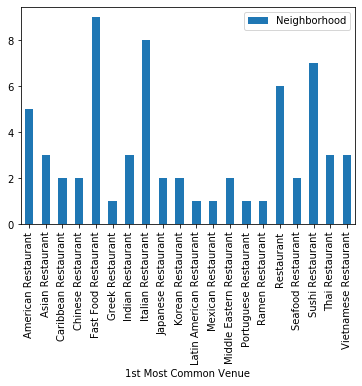

In [67]:

df_1.plot.bar()
plot.show()

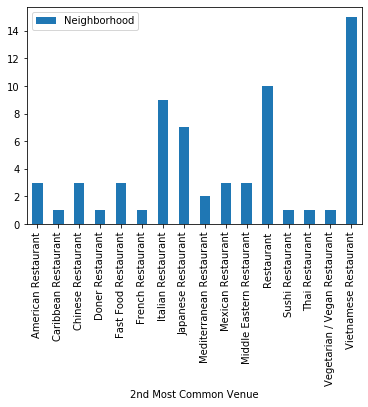

In [68]:
df_2.plot.bar()
plot.show()

In [89]:
toronto_cluster_0 = toronto_neighbor_venues_sorted.loc[toronto_neighbor_venues_sorted['Cluster Labels'] == 0, toronto_neighbor_venues_sorted.columns[[0] + list(range(1, 2))]]

toronto_cluster_1 = toronto_neighbor_venues_sorted.loc[toronto_neighbor_venues_sorted['Cluster Labels'] == 1, toronto_neighbor_venues_sorted.columns[[0] + list(range(1, 2))]]

toronto_cluster_2 = toronto_neighbor_venues_sorted.loc[toronto_neighbor_venues_sorted['Cluster Labels'] == 2, toronto_neighbor_venues_sorted.columns[[0] +  list(range(1, 2))]]

In [98]:
toronto_cluster_0
toronto_cluster_1.groupby('1st Most Common Venue').count()

,Neighborhood
1st Most Common Venue,
American Restaurant,5
Asian Restaurant,3
Caribbean Restaurant,2
Chinese Restaurant,2
Fast Food Restaurant,3
Greek Restaurant,1
Indian Restaurant,3
Italian Restaurant,8
Japanese Restaurant,2


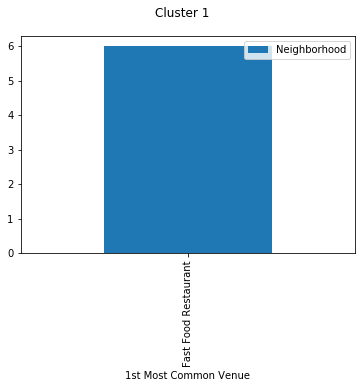

In [105]:
toronto_cluster_0.groupby('1st Most Common Venue').count().plot.bar()
plot.suptitle("Cluster 1")
plot.show()

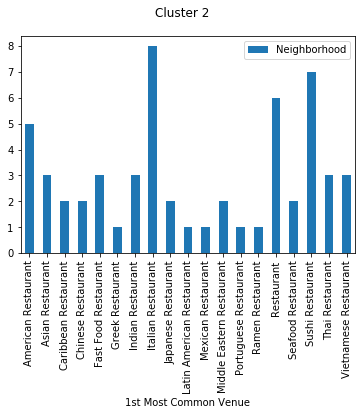

In [106]:
toronto_cluster_1.groupby('1st Most Common Venue').count().plot.bar()
plot.suptitle("Cluster 2")
plot.show()

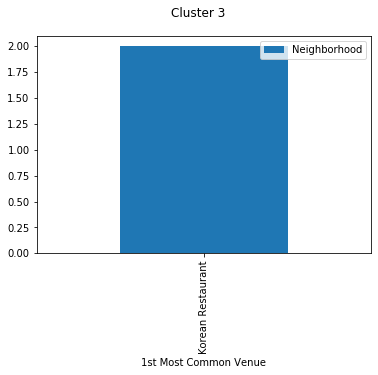

In [107]:
toronto_cluster_2.groupby('1st Most Common Venue').count().plot.bar()
plot.suptitle("Cluster 3")
plot.show()